In [0]:
import numpy as np
import pandas as pd
import torchvision
from google.colab import files

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
import torch
from PIL import Image
from torchvision import transforms

In [0]:
class Dataset(object):
    """An abstract class representing a Dataset.
    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

In [0]:
class DatasetMNIST(Dataset):
    
    def __init__(self, file_path, dataset=False, transform=None, test=False):
        if(file_path==False):
          self.data = dataset.as_matrix()
        elif(dataset==False):
          self.data = pd.read_csv(file_path).as_matrix()
        else:
          raise Exception('Dataset input ambiguous.')
        self.transform = transform
        self.test = test
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        if(not self.test):
          image = (self.data[index, 1:]).astype(np.uint8).reshape((28, 28))
          label = self.data[index, 0]
        else:
          image = (self.data[index, :]).astype(np.uint8).reshape((28, 28))
          label = np.nan
        
        image = Image.fromarray(image, mode='L')
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [0]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.2

transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5), (0.5, 0.5))
    ])

train_data = DatasetMNIST('train.csv', transform = transform)

test_data = DatasetMNIST('test.csv', transform = transform, test=True)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = [x for x in range(10)]

In [0]:
# helper function to un-normalize and display an image
def imshow(img):
    plt.imshow(np.squeeze(img))  # convert from Tensor image

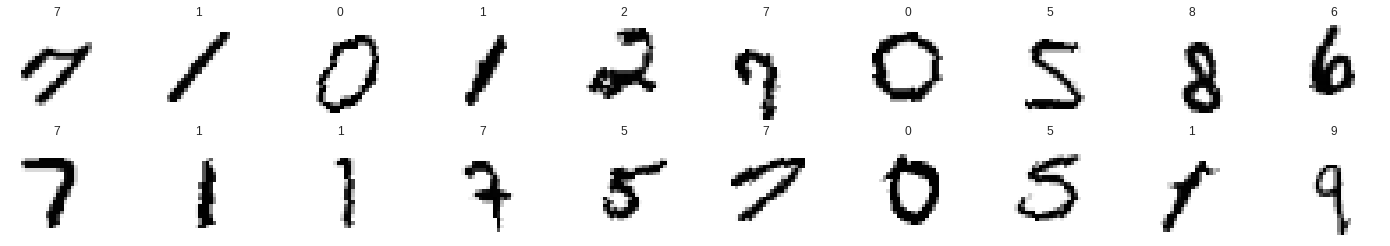

In [0]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 28x28x3 image tensor)
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv11 = nn.Conv2d(32, 32, 3, padding=1)
        # convolutional layer (sees 14x14x32 tensor)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv21 = nn.Conv2d(64, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 7 * 7, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.2)
        self.output = nn.LogSoftmax(dim=1)
        self.norm = nn.BatchNorm1d(500)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv11(F.relu(self.conv1(x)))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv21(F.relu(self.conv2(x)))))
        x = self.dropout(x)
        # flatten image input
        x = x.view(-1, 64 * 7 * 7)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.norm(x)
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        x = self.output(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv21): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
  (output): LogSoftmax()
  (norm): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [0]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1)

In [0]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss
        
        
    scheduler.step(valid_loss)

In [0]:
model.load_state_dict(torch.load('model_augmented.pt'))

In [0]:
for param_group in optimizer.param_groups:
  print(param_group['lr'])

1.0000000000000004e-08


In [0]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
batch_size = 16
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in valid_loader:
  
    data, target = data.to('cuda'), target.to('cuda')
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(valid_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.003924

Test Accuracy of     0: 99% (213/214)
Test Accuracy of     1: 99% (238/239)
Test Accuracy of     2: 99% (216/217)
Test Accuracy of     3: 99% (232/233)
Test Accuracy of     4: 99% (183/184)
Test Accuracy of     5: 100% (175/175)
Test Accuracy of     6: 99% (226/227)
Test Accuracy of     7: 99% (223/224)
Test Accuracy of     8: 100% (192/192)
Test Accuracy of     9: 98% (203/207)

Test Accuracy (Overall): 99% (2101/2112)


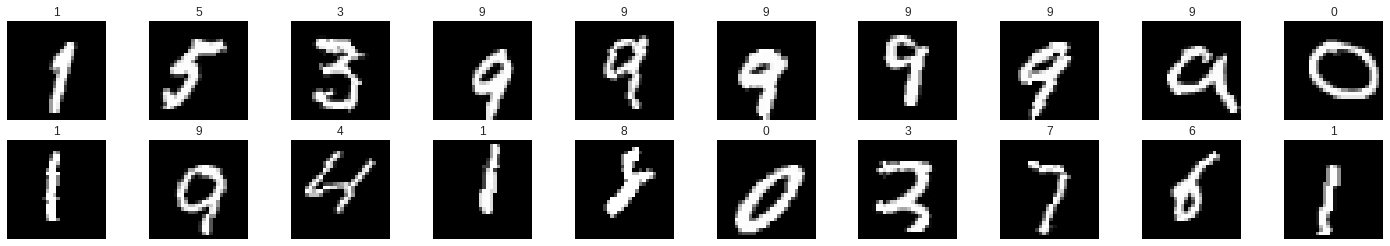

In [0]:
# obtain one batch of training images
dataiter = iter(valid_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [0]:
model.eval() # prep model for evaluation

predictions = []

for data, target in test_loader:
  
    data, target = data.to('cuda'), target.to('cuda')
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    ps = torch.exp(output)
    top_p, top_class = ps.topk(1, dim=1)
    predictions.append(top_class)
model.train()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv21): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
  (output): LogSoftmax()
  (norm): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [0]:
predictions = [i.to('cpu').numpy().tolist() for i in predictions]
predictions = [j for sub in predictions for j in sub]
predictions = [j for sub in predictions for j in sub]

In [0]:
test_set = pd.read_csv("test.csv")

In [0]:
test_set.insert(loc=0, column='Label', value=predictions)

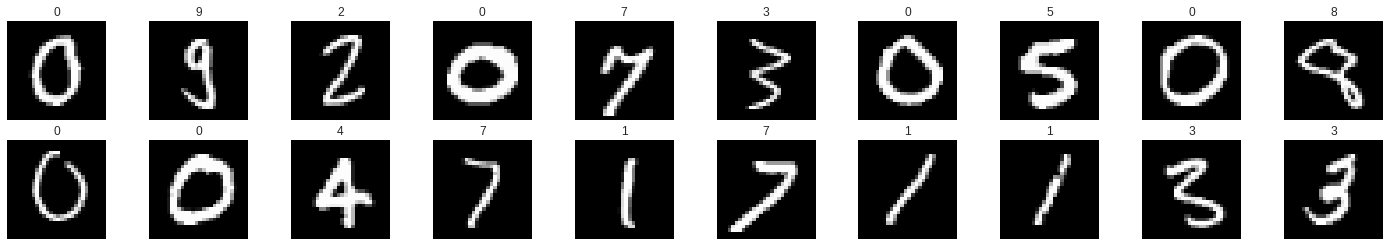

In [0]:
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(100,120):
    image = test_set.as_matrix()[idx, 1:].reshape(28,28)
    ax = fig.add_subplot(2, 20/2, idx-99, xticks=[], yticks=[])
    ax.imshow(np.squeeze(image), cmap='gray')
    ax.set_title(str(predictions[idx]))
    

In [0]:
df = pd.DataFrame({'ImageId':[x+1 for x in range(28000)], 'Label':predictions})

In [0]:
df.to_csv('submission.csv', index=False)